In [1]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.path as mpath

from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
from scipy.interpolate import interpn
import math
import warnings

%matplotlib inline

import xarray as xr
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')

from matplotlib import cm


In [4]:
ds = xr.open_dataset('/scratch/project_2000789/muramarg/run_5_27/output_WAOM_check/ocean_flt.nc')
x = (ds.variables['Xgrid'].values)
x[10561]

array([523.1696 , 514.95636, 521.5358 , 523.54755, 523.0709 , 522.5006 ,
       517.0443 , 538.07227, 528.34033, 533.5761 , 518.751  , 537.1452 ,
       522.9783 , 517.7637 , 514.40094, 534.7563 , 518.7408 , 514.42596,
       517.89813, 534.05194, 526.2064 , 529.7629 , 522.3052 , 518.91766,
       516.44275, 526.44025, 519.29205, 525.2241 , 520.03394, 516.70337,
       518.8421 , 515.79315, 517.68164, 518.4723 , 524.36835, 529.85925,
       520.9296 , 517.6432 , 520.04877, 519.05505, 515.75085, 518.3034 ,
       516.68036, 521.2397 , 523.1547 , 521.30145, 523.91095, 518.54425,
       528.70593, 518.84125, 534.4637 , 515.50085, 518.9395 , 528.04205,
       534.6132 , 518.3289 , 536.6908 , 514.3698 , 516.9908 , 516.631  ,
       518.71625, 526.94006, 517.2653 , 522.1848 , 515.8812 , 516.83813,
       517.8102 , 524.3039 , 519.49384, 523.86316, 518.94135, 517.1973 ,
       523.96   , 515.56366, 520.97345, 526.0759 , 519.0888 , 530.4601 ,
       516.09534, 517.7172 , 537.0535 , 537.7088 , 

In [2]:
dg = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10_frc/waom10extend_grd.nc')
ds = xr.open_dataset('/scratch/project_2000789/boeiradi/waom10extend_shflim_S_0.25Q/output_01-20yr/ocean_avg_0016.nc')

In [3]:
ds

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 31, s_w: 32, eta_rho: 560, xi_rho: 630, eta_u: 560, xi_u: 629, eta_v: 559, xi_v: 630, eta_psi: 559, xi_psi: 629, ocean_time: 12)
Coordinates:
  * s_rho          (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
  * s_w            (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.06452 -0.03226 0.0
    x_rho          (eta_rho, xi_rho) float64 ...
    y_rho          (eta_rho, xi_rho) float64 ...
    x_u            (eta_u, xi_u) float64 ...
    y_u            (eta_u, xi_u) float64 ...
    x_v            (eta_v, xi_v) float64 ...
    y_v            (eta_v, xi_v) float64 ...
    x_psi          (eta_psi, xi_psi) float64 ...
    y_psi          (eta_psi, xi_psi) float64 ...
  * ocean_time     (ocean_time) datetime64[ns] 2022-01-12T05:00:00 ... 2022-1...
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, eta_u, xi_u, eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/96)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    v_temp         (ocean_time, s_rho, eta_v, xi_v) float32 ...
    u_salt         (ocean_time, s_rho, eta_u, xi_u) float32 ...
    v_salt         (ocean_time, s_rho, eta_v, xi_v) float32 ...
    shflux         (ocean_time, eta_rho, xi_rho) float32 ...
    ssflux         (ocean_time, eta_rho, xi_rho) float32 ...
    swrad          (ocean_time, eta_rho, xi_rho) float32 ...
Attributes: (12/34)
    file:              /scratch/gh9/fbd581/ROMS/waom10extend_shflim_S_0.25Q/o...
    format:            netCDF-4/HDF5 file
    Conventions:       CF-1.4
    type:              ROMS/TOMS nonlinear model averages file
    title:             Whole Antarctic and Ocean Application, 10 km resolution
    rst_file:          /scratch/gh9/fbd581/ROMS/waom10extend_shflim_S_0.25Q/o...
    ...                ...
    compiler_command:  /apps/openmpi/4.0.2/bin/mpif90
    compiler_flags:    -heap-arrays -fp-model precise -g -ip -O3 -free -free ...
    tiling:            018x016
    history:           ROMS/TOMS, Version 3.7, Thursday - April 15, 2021 -  2...
    ana_file:          ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_sr...
    CPP_options:       WAOM10extend, ADD_FSOBC, ADD_M2OBC, ANA_BSFLUX, ANA_BT...

In [4]:
#(ocean_time=slice(47, None, 7*24),xi_rho=slice(300, None))
len(ds.coords['ocean_time'])

12

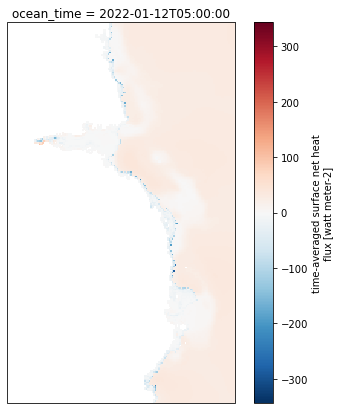

In [5]:
#open dataset
#ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
ds.coords["lon_rho"] = dg.lon_rho
ds.coords["lat_rho"] = dg.lat_rho

proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
#fig, axes = plt.subplots(2)
for i in range(1):
    fig = plt.figure(figsize=(7,7))
    plt.axes(projection=proj)
    ds.shflux.isel(ocean_time=[i],xi_rho=slice(450, 600),eta_rho=slice(200,450)).plot(x="lon_rho", y="lat_rho",transform=ccrs.PlateCarree())

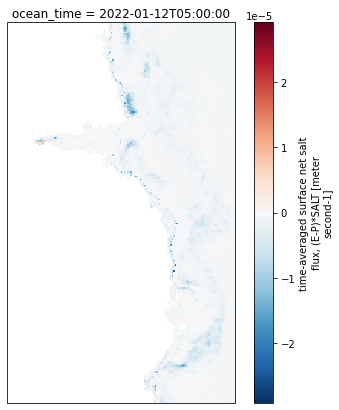

In [6]:
#open dataset
#ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
ds.coords["lon_rho"] = dg.lon_rho
ds.coords["lat_rho"] = dg.lat_rho

proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
#fig, axes = plt.subplots(2)
for i in range(1):
    fig = plt.figure(figsize=(7,7))
    plt.axes(projection=proj)
    ds.ssflux.isel(ocean_time=[i],xi_rho=slice(450, 600),eta_rho=slice(200,450)).plot(x="lon_rho", y="lat_rho",transform=ccrs.PlateCarree())

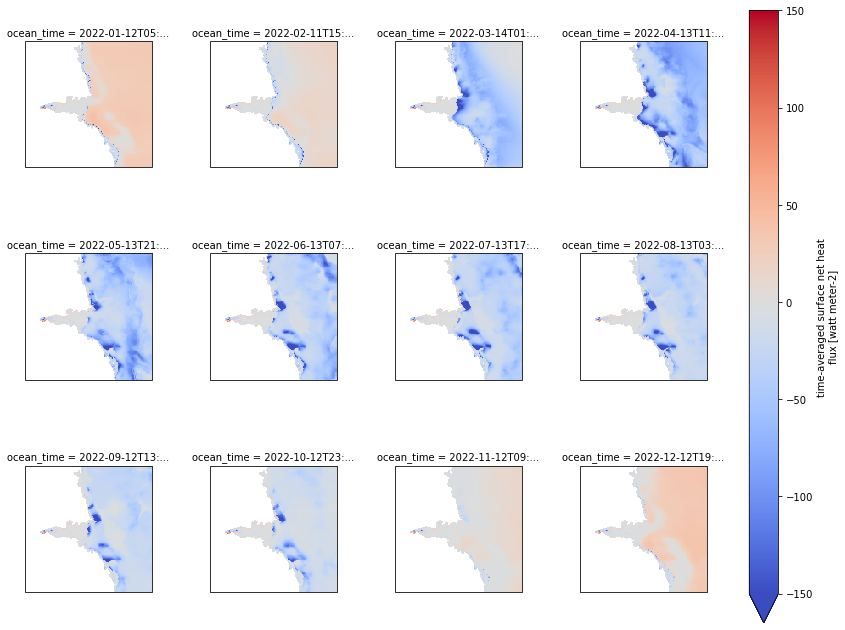

In [17]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
sh = ds.shflux.isel(ocean_time=[0,1,2,3,4,5,6,7,8,9,10,11],xi_rho=slice(450, 600),eta_rho=slice(300,450))

p = sh.plot(transform=ccrs.PlateCarree(),  # the data's projection
              x="lon_rho", y="lat_rho",col='ocean_time',col_wrap=4,  
             subplot_kws={'projection': map_proj}, vmin=-150, vmax=150, cmap=cm.get_cmap('coolwarm'))  # the plot's projection

#plt.savefig("shf.png")
plt.show()

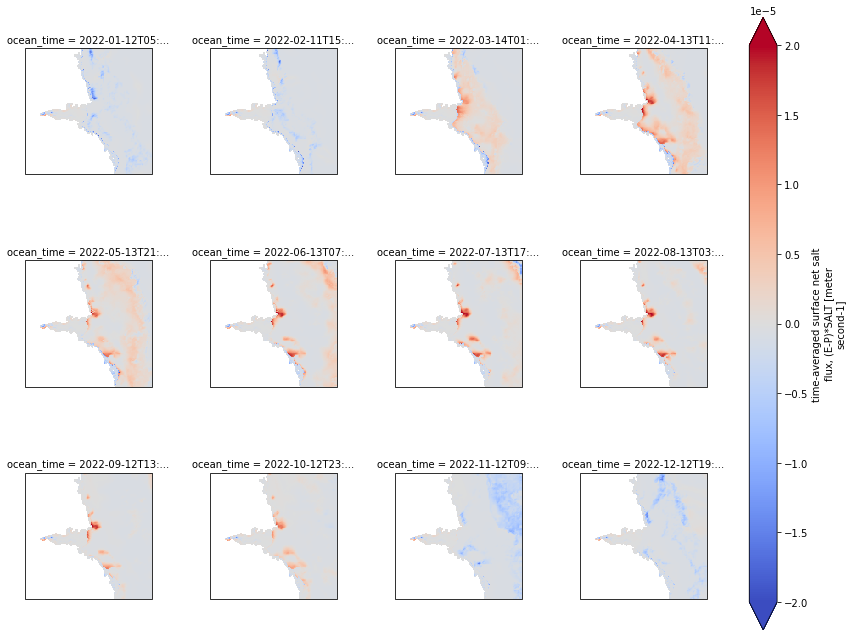

In [18]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
ss = ds.ssflux.isel(ocean_time=[0,1,2,3,4,5,6,7,8,9,10,11],xi_rho=slice(450, 600),eta_rho=slice(300,450))

p = ss.plot(transform=ccrs.PlateCarree(),  # the data's projection
              x="lon_rho", y="lat_rho",col='ocean_time',col_wrap=4,  
             subplot_kws={'projection': map_proj}, vmin=-2e-5, vmax=2e-5, cmap=cm.get_cmap('coolwarm'))  # the plot's projection

#plt.savefig("ssf.png")
plt.show()

In [48]:
#look at july only (ocean_time=0)
map_proj = ccrs.SouthPolarStereo(central_longitude=0.0, true_scale_latitude=None, globe=None)
sh = ds.shflux.isel(ocean_time=[0],xi_rho=slice(450, 600),eta_rho=slice(300,450))

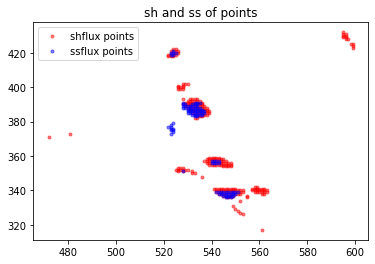

In [284]:
def sh_points(ds,thres,month,xr,yr):
    """
    inputs: the dataset
    thres: the threshold value for flux
    month: the index of desired month
    xr: range of x values to include
    yr: range of y values to include
    
    outputs: the x and y grid locations for the threshold values
    """
    sh_arr = (ds.shflux.values)[month]
    locs = np.where(sh_arr < thres)         # set values above the heat loss threshold to 0

    # filter by area on the map
    newx = np.array([])
    newy = np.array([])
    for i,j in zip(locs[1],locs[0]):
        if (i>xr[0] and i<xr[1]) and (j>yr[0] and j<yr[1]):
            newx = np.append(i,newx)
            newy = np.append(j,newy)
            
    return newx,newy

def ss_points(ds,thres,month,xr,yr):
    """
    inputs:
        ds: the dataset
        thres: the threshold value for flux
        month: the index of desired month
        xr: range of x values to include
        yr: range of y values to include
    
    outputs: 
        newx, newy: the x and y grid locations for the threshold values
    """
    ss_arr = (ds.ssflux.values)[month]
    locs = np.where(ss_arr > thres)         # set values above the heat loss threshold to 0

    # filter by area on the map
    newx = np.array([])
    newy = np.array([])
    for i,j in zip(locs[1],locs[0]):
        if (i>xr[0] and i<xr[1]) and (j>yr[0] and j<yr[1]):
            newx = np.append(i,newx)
            newy = np.append(j,newy)
            
    return newx,newy

def mergepoints(x1,y1,x2,y2):
    """
    inputs:
        x1,y1: the x and y coordinates of two arrays
        x2,y2: the x and y coordinates of two arrays
    outputs:
        x,y: the combined arrays of two datapoints
    """
    # create the new set of points
    pts1 = np.empty((0,2))
    pts2 = np.empty((0,2))
    
    # read through each array, create points as tuples
    for i,j in zip(x1,y1):
        l = np.array([i,j])
        pts1 = np.append(np.array([l]),pts1,axis=0)
    for i,j in zip(x2,y2):
        l = np.array([i,j])
        pts2 = np.append(np.array([l]),pts2,axis=0)
        
    # union of the two sets
    set1 = set([tuple(x) for x in pts1])
    set2 = set([tuple(x) for x in pts2])
    pts = np.array([x for x in set1 and set2])
#     pts2 = np.array([x for x in set1 and set2])
#     for pt in pts2:
#         #print(pt)
#         pts = np.append(np.array([pt]),pts,axis=0)
    
    # separate into x and y arrays again
    x = np.array([])
    y = np.array([])
    for pt in pts:
        x = np.append(pt[0],x)
        y = np.append(pt[1],y)
    
    return x,y
    
xh,yh = sh_points(ds,-120,6,[450,600],[300,450])
xs,ys = ss_points(ds,1.3e-5,6,[450,600],[300,450])
plt.plot(xh,yh,'.',color="r",alpha=0.5,label='shflux points')
plt.plot(xs,ys,'.',color="b",alpha=0.5,label='ssflux points')
plt.title("sh and ss of points")
plt.legend()

105


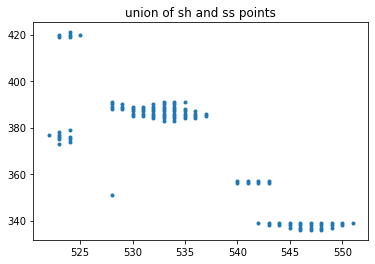

In [285]:
x,y = mergepoints(xh,yh,xs,ys)
plt.plot(x,y,'.')
plt.title("union of sh and ss points")
print(len(x))

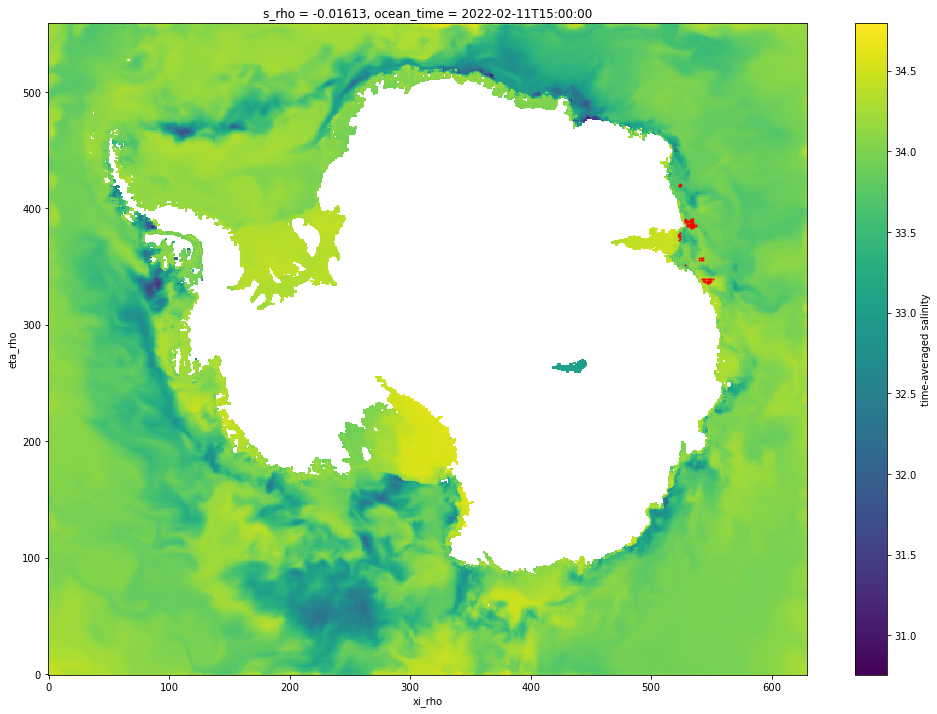

In [286]:
# THESE ARE IN GRID POINTS
fig = plt.figure(figsize=(17,12))
ds.salt.isel(s_rho=-1, ocean_time=1).plot()
plt.plot(x,y,'.',markersize=2, color='r')
plt.savefig("points137.png")
plt.show()

In [287]:
# write the above to a text file
firstline = 'POS = G, C, T, N,   Ft0,    Fx0,    Fy0,    Fz0,    Fdt,    Fdx,    Fdy,   Fdz'
secline = ''
G = "1"
C = "0"
T = "1"
N = "1"
Ft0 = '0.1d0'

Fz0 = '-1.0d0'
Fdt = '7.0d0'
Fdx = '0.0d0'
Fdy = '0.0d0'
Fdz = '0.0d0'
lines = [firstline, secline]
for i,j in zip(x,y):
    # create the line to add to lines
    line = "\t"+G+"  "+C+"  "+T+"  "+N+"   "+Ft0+"   "+str(i)+"d0   "+str(j)+"d0   "+Fz0+"   "+Fdt+"   "+Fdx+"   "+Fdy+"   "+Fdz
    lines.append(line)
with open('points.txt', 'w') as f:
    for line in lines:
        f.write(line)
        f.write('\n')
f.close()

In [288]:
print(len(x))

105
